# Разработка стратегии взаимодействия с клиентами сети фитнес-центров 

## Описание проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для борьбы с оттоком, отдел по работе с клиентами  перевёл в электронный вид множество клиентских анкет. Цель — провести анализ и подготовить план действий по удержанию клиентов.

Для этого необходимо:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  - выделить целевые группы клиентов;
  - предложить меры по снижению оттока;
  - определить другие особенности взаимодействия с клиентами.

## Описание данных

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Предобработка данных

Для работы с данными импортируем необходимые библиотеки:

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

Перед началом исследования необходимо убедиться в корректности предоставленной информации. Изучим данные в таблицах:

In [16]:
try:
    df = pd.read_csv('gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')
display(df.head())
df.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В результате первичного изучения выявлено:
- Пропуски отсутствуют;
- Названия столбцов таблицы имеют разный регистр. Приведем названия к общему виду;
- Столбец `gender`(пол) принимает значения 0 и 1, в результате неизвестно кто относится к женщинам, а кто к мужчинам. Возможно при дальнейшем исследовании данная информация не понадобится;
- Столбец `Month_to_end_contract`(срок до окончания текущего действующего абонемента в месяцах) имеет вещественный тип данных, для удобства переведем в целочисленный.

In [17]:
# приведение названий столбцов к общему виду
df.columns = df.columns.str.lower()

# приведение к целочисленному типу данных
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


Проверим наличие дубликатов:

In [18]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


## Исследовательский анализ данных

Изучим средние значения и стандартные отклонения датасета. Воспользуемся методом `describe`. Также посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом `groupby`).

In [19]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [20]:
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Средний возраст посетителей фитнес-центра - 29 лет. Время с начала первого посещения и время до окончания действия абонемента примерно одинаковое - около 4 месяцев. Частота посещений в среднем около 2 раз в неделю. Если рассматривать показатели по группам (кто ушел в отток/кто остался), то в некоторых  из них наблюдается существенная разница. Так например, те кто ушел в отток брали абонемент в основном на 1 месяц, когда как средний показатель для тех, кто остался составляет 6 месяцев. Также видно, что те кто ушел являлись более молодыми клиентами, которые первый раз посетили фитнес-центр в течение прошлого месяца. Данная категория клиентов тратила меньше средств на другие услуги фитнес-центра: кафе, спорттовары, косметический и массажный салон. В итоге, можно предположить, что клиенты которые ушли, брали абонемент в ознакомительных целях, чтобы оценить возможности и качество услуг данного фитнес-центра, поэтому и срок абонемента и частота посещения меньше, чем у тех кто остался.

Посмотрим, есть ли какие-то аномальные выбросы в значениях, и как вообще ведут себя признаки. Для этого построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

'age'

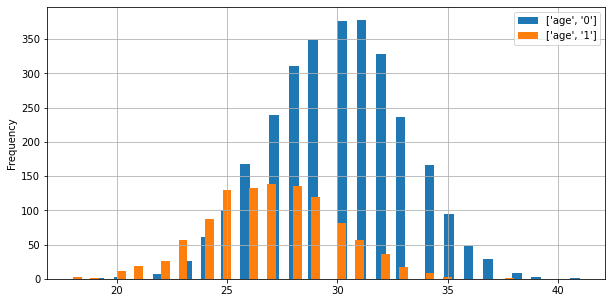

'avg_additional_charges_total'

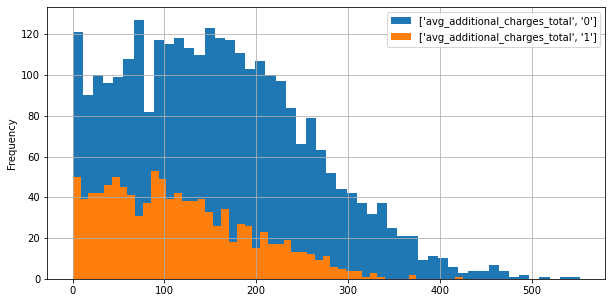

'lifetime'

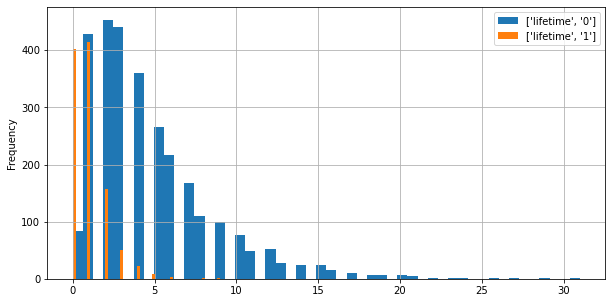

'avg_class_frequency_total'

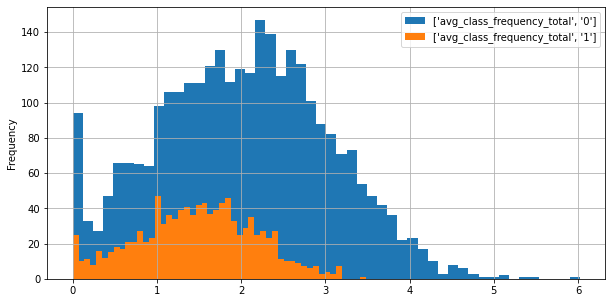

'avg_class_frequency_current_month'

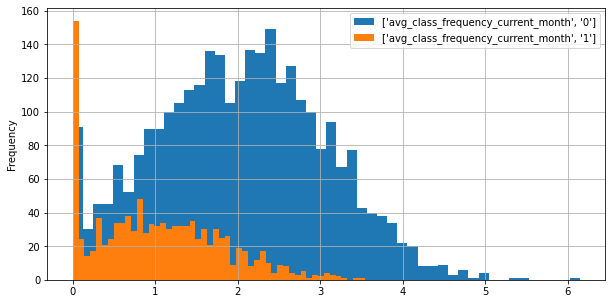

In [21]:
sign_list = ['age', 'avg_additional_charges_total','lifetime', 'avg_class_frequency_total','avg_class_frequency_current_month']
df_churn_0 = df.query('churn == 0')
df_churn_1 = df.query('churn == 1')
for sign in sign_list:
    display(sign)
    df_churn_0[sign].plot(kind='hist', bins=50, figsize=(10, 5), grid=True)
    df_churn_1[sign].plot(kind='hist', bins=50, figsize=(10, 5), grid=True)
    plt.legend([[sign,'0'],[sign,'1']])
    plt.show()

'contract_period'

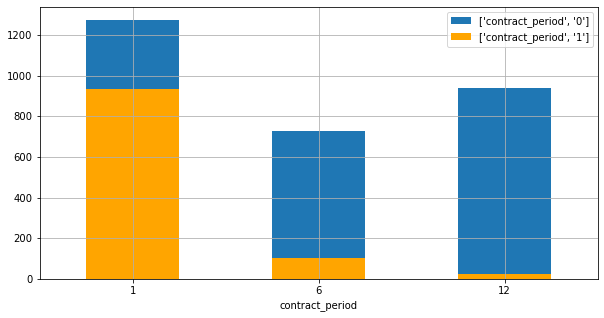

'month_to_end_contract'

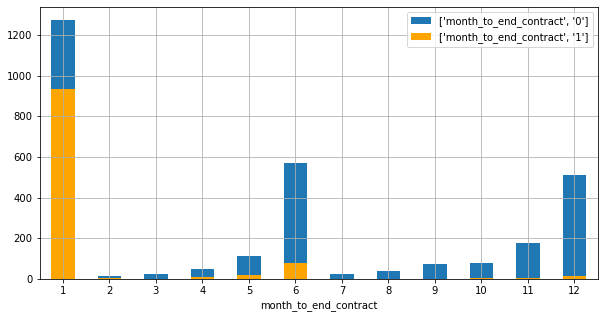

In [22]:
sign_list_category = ['contract_period', 'month_to_end_contract']
df_churn_0 = df.query('churn == 0')
df_churn_1 = df.query('churn == 1')
for sign in sign_list_category:
    display(sign)
    df_churn_0.groupby(sign)[sign].agg('count').plot(kind='bar', figsize=(10, 5), grid=True)
    df_churn_1.groupby(sign)[sign].agg('count').plot(kind='bar', figsize=(10, 5), color='orange', grid=True)
    plt.legend([[sign,'0'],[sign,'1']])
    plt.xticks(rotation=0) 
    plt.show()

Каких-то ярких выбросов и аномалий не наблюдается. Достаточно много клиентов не посещают фитнес-центр даже раз в неделю. Также можно наблюдать, что большинство клиентов предпочитают одномесячный абонемент.

Рассчитаем матрицу корреляций и на её основе построим `heatmap`.

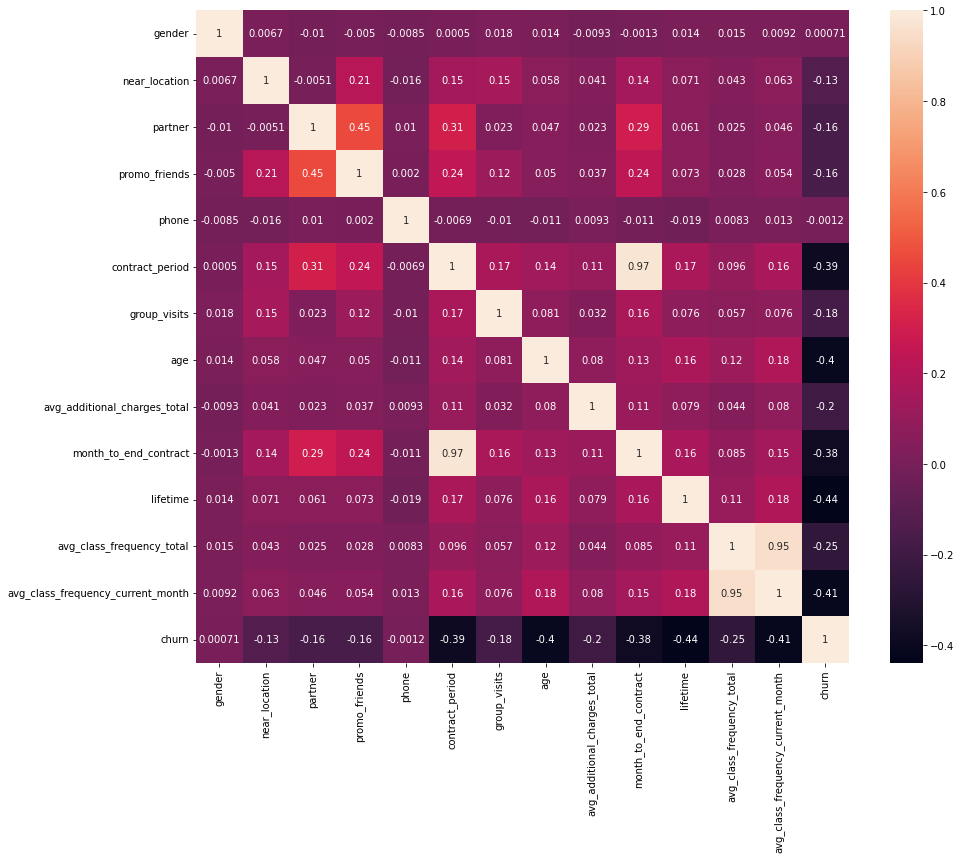

In [23]:
cm = df.corr() # вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(15,12))

# тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
plt.show()

На матрице видно, что с целевой переменной наиболее сильно коррелируют следующие признаки:
- `contract_period` - срок абонемента;
- `age` - возраст клиента;
- `month_to_end_contract` - срок до окончания текущего действующего абонемента (в месяцах); 
- `lifetime` - время с момента первого обращения в фитнес-центр (в месяцах);
- `avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц.

Также наблюдаются признаки, которые сильно коллерируют между собой: `contract_period` с `month_to_end_contract` и `avg_class_frequency_total` с `avg_class_frequency_current_month`. С учетом того, что взаимная корреляция для линейных моделей нежелательна, а такие в проекте использоваться не будут, от мультиколлинеарности можно не избавляться. Все остальные признаки незначительно коррелируют с целевой переменной.

## Построение модели прогнозирования оттока клиентов

Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
Разделим данные на обучающую и валидационную выборку функцией `train_test_split()`. После обучим модель на train-выборке двумя способами:
- логистической регрессией;
- случайным лесом.

In [24]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
 # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


У двух моделей хорошие показатели метрики. Лучше себя показала логистическая регрессия. Здесь значения точности и полноты чуть выше, чем у модели случайного леса. Тем не менее оценка качества классификатора (модели классификации, параметр `roc_auc`) у них одинаковая.

## Кластеризация клиентов

Уберем столбец с оттоком и проведем кластеризацию клиентов. Для начала стандартизируем данные. Далее создадим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

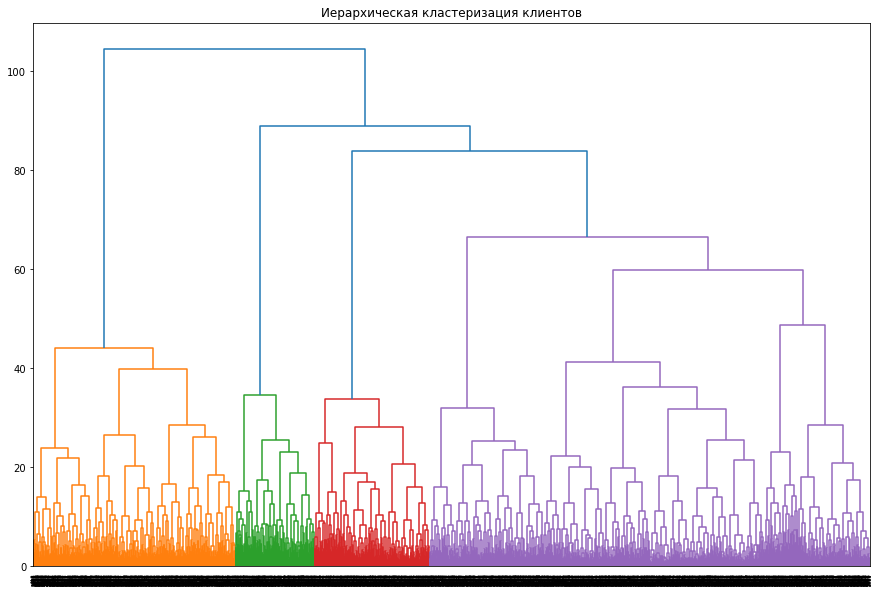

In [25]:
data = df.drop(columns = ['churn'])
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(data) # обучаем нормализатор и преобразуем набор данных 

linked = linkage(x_sc, method = 'ward') # матрица расстояний

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

Обучите модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов. За число кластеров примем `n=5`. 

In [26]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата 
distance = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = distance.fit_predict(x_sc) 

# сохраняем метки кластера в поле нашего датасета
df['cluster_distance'] = labels
 
# выводим статистику по средним значениям наших признаков по кластеру
display(df.groupby('cluster_distance').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_distance,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Построим распределения признаков для кластеров:

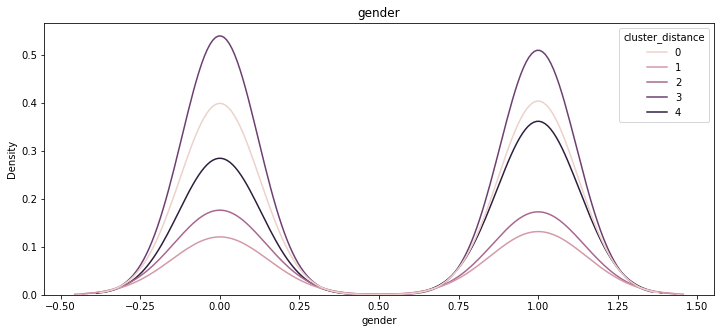

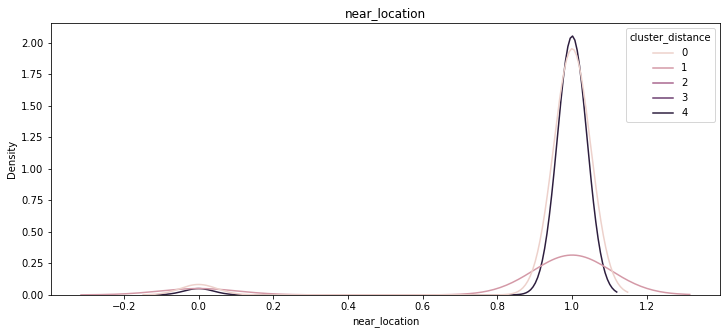

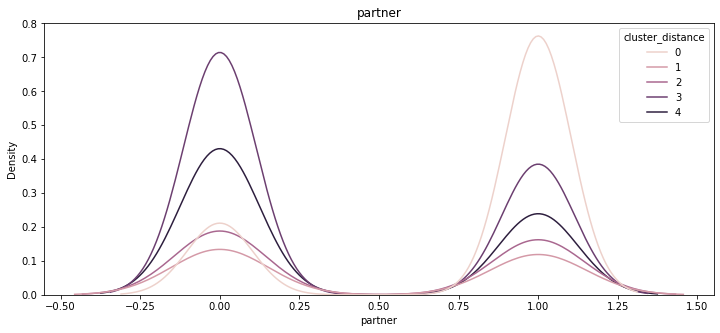

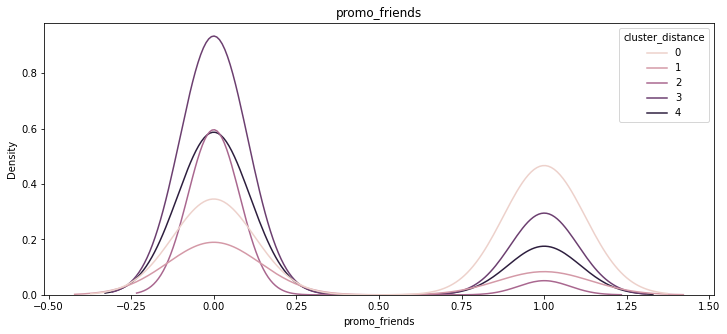

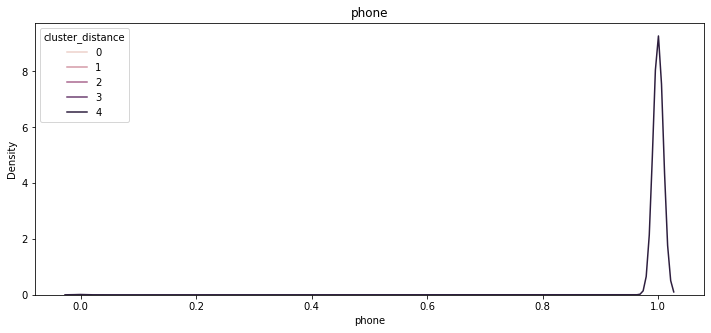

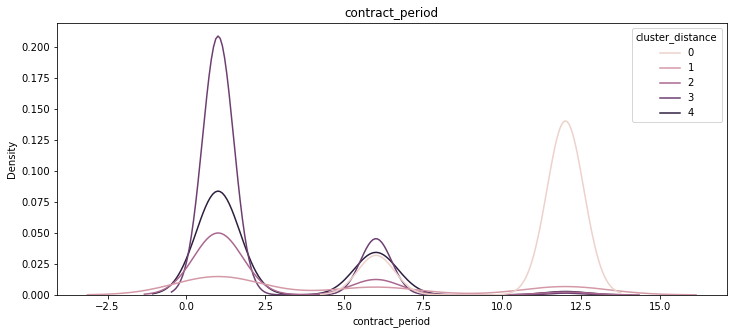

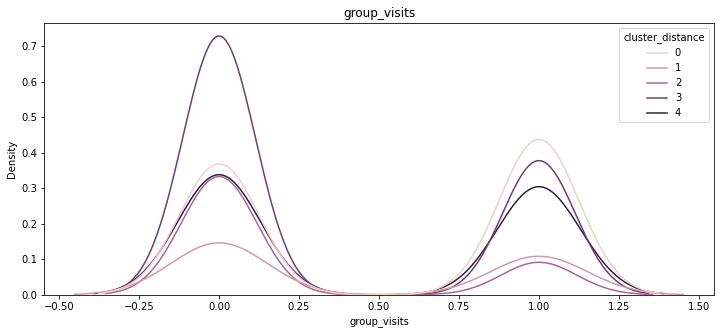

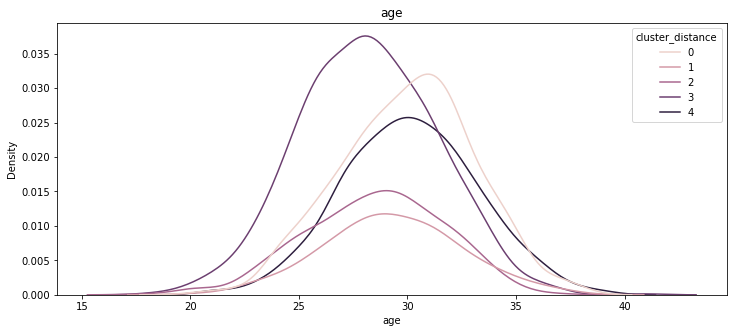

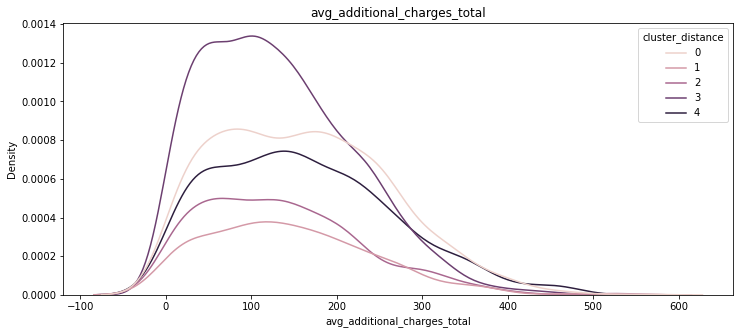

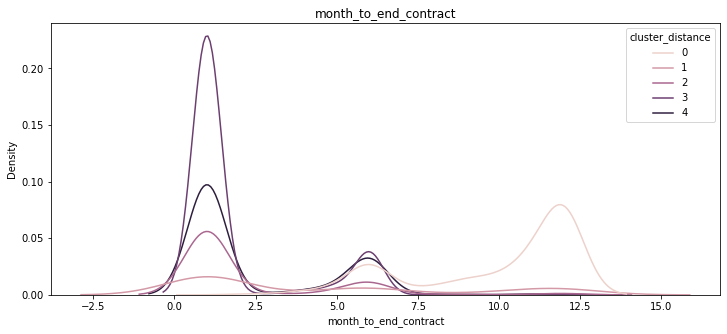

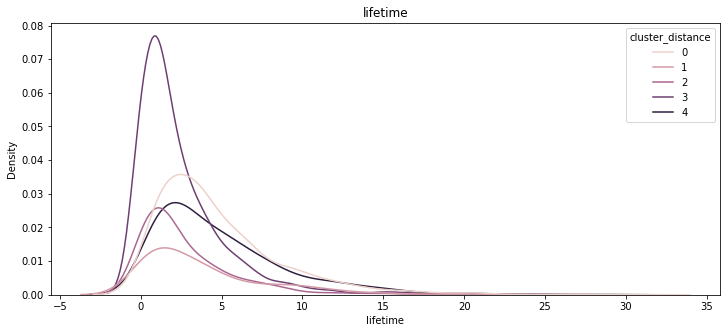

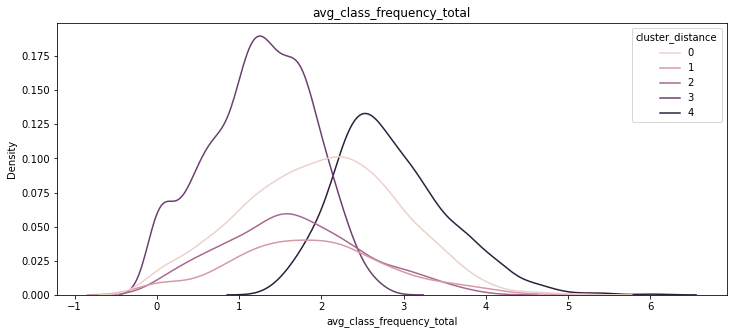

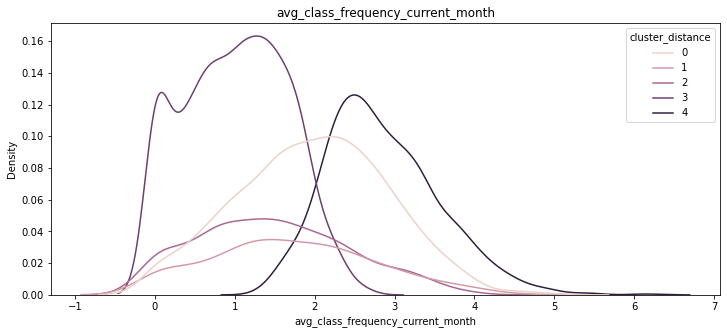

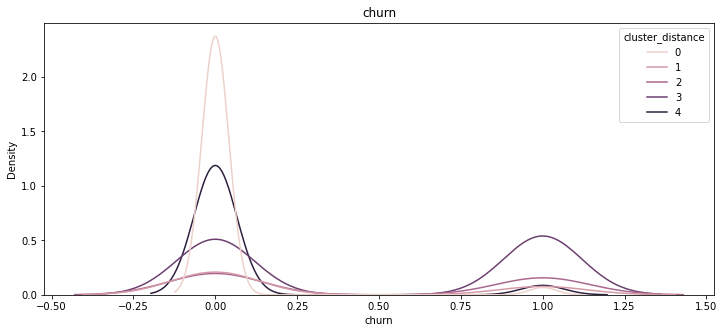

In [27]:
# построение распределения признаков для кластеров
for column in df.drop('cluster_distance', axis=1).columns:
    plt.figure(figsize=(12,5))
    sns.kdeplot(x=df[column], hue='cluster_distance', data=df)
    plt.title(column)
    plt.show()

На графиках распределения признаков сильнее других выделяются 3 кластера - 0, 3 и 4. Если проводить аналогию с гистограммами признаков на начальном этапе исследования, то можно заметить, что показатели 3 кластера схожи с показателями группы клиентов, которые покинули фитнес-центр в текущем месяце. Такая же ситуация с 0 кластером и теми, кто остался. Сюда же можно добавить и 4 кластер, который характеризует оставшихся клиентов.

Исходя из вышесказанного, можно предположить, что любой случайно взятый клиент из кластера 3 с большей вероятностью окажется ушедшим из фитнес-центра, а случайно взятый клиент из 0 или 4 кластера вероятно в нем останется.

Проверим наши предположения. Посчитаем для каждого полученного кластера долю оттока (методом `groupby()`).

In [28]:
cluster_churn = df.groupby('cluster_distance').agg({'cluster_distance':'count','churn':'sum'})
cluster_churn['churn,%'] = round(cluster_churn['churn']/cluster_churn['cluster_distance']*100,1)
cluster_churn

,cluster_distance,churn,"churn,%"
cluster_distance,,,
0,1010,28,2.8
1,385,103,26.8
2,505,224,44.4
3,1262,649,51.4
4,838,57,6.8


Наши предположения совпадают с полученными цифрами. Действительно, больше всего склонен к оттоку 3 кластер (доля оттока более 50%). К группе "ненадежных" можно добавить и 2 кластер (доля оттока 44.4%). Самые надежные кластеры 0 и 4 (доля оттока 2.8% и 6.8% соответственно).

## Общий вывод

Цель проекта - провести анализ и подготовить план действий по удержанию клиентов фитнес-центра. В начале исследования была проведена подготовка данных к анализу, а именно:
- Названия столбцов приведены к единому виду;
- Проверено наличие пропусков и дубликатов;
- Значения в таблице приведены к нужному типу данных.

Далее, для выполнения задачи был проведен исследовательский анализ данных, в ходе которого были изучены основные позиции по клиентам фитнес-центра и определены основные портреты клиентов. В результате установлено:
- Портрет постоянного клиента:
    - Средний возраст - 30 лет;
    - Продолжительность абонемента от 6 месяцев;
    - Частота посещений в неделю - 2 раза.
    
- Портрет ушедшего клиента:
    - Средний возраст - 26 лет;
    - Продолжительность абонемента - 1 месяц;
    - Частота посещений в неделю - 1 раз. 
 
Затем были построены модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Модели были обучены двумя способами: логистическая регрессия и случайный лес. В результате, лучше себя показала логистическая регрессия. Здесь значения точности и полноты чуть выше, чем у модели случайного леса. Тем не менее оценка качества классификатора (модели классификации, параметр `roc_auc`) у них одинаковая.

По кластеризации клиентов можно выделить следующие моменты:
- Оптимальное число кластеров - 4;
- Ненадежные кластеры - 2 и 3 (доля оттока 44.4% и 51.4% соответственно);
- Самые надежные кластеры 0 и 4 (доля оттока 2.8% и 6.8% соответственно).

В итоге, чтобы выделить рекомендации по удержанию клиентов, необходимо взглянуть на возможные причины оттока посетителей:
- Нехватка времени;
- Отсутствие немедленных результатов;
- Травмы (неправильная техника выполнения упражнения);
- Отсутствие мотивации;
- Стоимость абонемента.

Исходя из портрета ушедшего клиента и выделенных причин оттока, сформулиуем основные рекомендации по повышению качества работы с клиентами:
- Более внимательная работа с новыми клиентами (индивидуальный подход к каждому), помощь инструкторов в осноении тренажеров. В каждый абонемент включить одно бесплатное занятие с тренером;
- Провести работу по повышению мотивации клиентов (например разместить в тренажерном зале различные мотивационные плакаты, запустить мотивационные видеоролики на телевизионных экранах);
- Скидки на повторное приобретение абонемента.